In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import torch.nn.functional as F

# We'll be using Pytorch's text library called torchtext! 
from torchtext.datasets import AG_NEWS
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import torchtext.transforms as T

from tqdm.notebook import trange, tqdm
from sklearn.model_selection import train_test_split

# print(torch.__version__)
# print(torch.cuda.is_available())
# print(torch.cuda.current_device())
# print(torch.cuda.device(0))
# print(torch.cuda.device_count())
# print(torch.cuda.get_device_name(0))

In [47]:
# Define the hyperparameters
learning_rate = 2e-4  # Learning rate for the optimizer
nepochs = 20  # Number of training epochs
batch_size = 8  # Batch size for training

max_len = 64  # Maximum length of input sequences
# Load the data from Excel
data = pd.read_excel(r'C:\Users\xxz76\OneDrive\2024Fall_PSU_MS\CSE584\Project\project1\dataset_project1\20240928project1_data2.xlsx')  

## Split data into train and test

In [48]:
# Drop rows where any of the necessary columns (label or text) have empty values
data.dropna(subset=[data.columns[0], data.columns[1]], inplace=True)

# Convert the DataFrame to a list of tuples
dataset = list(zip(data.iloc[:, 0], data.iloc[:, 1]))

# Split the dataset into training and test sets
dataset_train, dataset_test = train_test_split(dataset, test_size=0.1, random_state=42)

# Now you can access each data point in the training set as a tuple (label, text)
label, text = dataset_train[0]  # Example of accessing the first element

## Dataset, Tokenizers and Vocab!

In [49]:
# Tokenization is the process of splitting a text into individual words or tokens.
# Here, we use the `get_tokenizer` function from the `torchtext.data.utils` module
# to create a tokenizer based on the "basic_english" tokenization method.
tokenizer = get_tokenizer("basic_english")

# Define a generator function `yield_tokens` to yield tokens from the data iterator.
# The data iterator provides pairs of (label, text) where text is the input sentence.
def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)

# Build the vocabulary from the tokens yielded by the `yield_tokens` generator function.
# We set `min_freq=2` to include a token only if it appears more than 2 times in the dataset.

# We will also add "special" tokens that we'll use to signal something to our model
# <pad> is a padding token that is added to the end of a sentence to ensure 
# the length of all sequences in a batch is the same
# <sos> signals the "Start-Of-Sentence" aka the start of the sequence
# <eos> signal the "End-Of-Sentence" aka the end of the sequence
# <unk> "unknown" token is used if a token is not contained in the vocab
vocab = build_vocab_from_iterator(
    yield_tokens(dataset_train),  # Tokenized data iterator
    min_freq=2,  # Minimum frequency threshold for token inclusion
    specials=['<pad>', '<sos>', '<eos>', '<unk>'],  # Special case tokens
    special_first=True  # Place special tokens first in the vocabulary
)

# Set the default index of the vocabulary to the index of the '<unk>' token.
# If a token is not found in the vocabulary, it will be replaced with the '<unk>' token.
vocab.set_default_index(vocab['<unk>'])

In [50]:
tokenizer = get_tokenizer("basic_english")

def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)

vocab = build_vocab_from_iterator(
    yield_tokens(dataset_train),  # Tokenized data iterator
    min_freq=2,  # Minimum frequency threshold for token inclusion
    specials=['<pad>', '<sos>', '<eos>', '<unk>'],  # Special case tokens
    special_first=True  # Place special tokens first in the vocabulary
)

vocab.set_default_index(vocab['<unk>'])

In [51]:
# Lets have a look at the vocab!
vocab.get_itos()
len(vocab)

2862

In [52]:
# Example demonstrating tokenization using the tokenizer created earlier.
# We extract the label and text of the first item in the training dataset.
label, text = dataset_train[0]

# Print the original text.
print("Original Text:")
print(text)

# Tokenize the text using the tokenizer.
print("\nTokenized Text:")
print(tokenizer(text))

Original Text:
On my way to the science center, I thought about all the interactive exhibits that would fascinate my curious kids.

Tokenized Text:
['on', 'my', 'way', 'to', 'the', 'science', 'center', ',', 'i', 'thought', 'about', 'all', 'the', 'interactive', 'exhibits', 'that', 'would', 'fascinate', 'my', 'curious', 'kids', '.']


In [53]:
# Define a text transformation pipeline using TorchText Sequential Transform
text_tranform = T.Sequential(
    # Convert the sentences to indices based on the given vocabulary
    T.VocabTransform(vocab=vocab),
    # Add <sos> at the beginning of each sentence. 1 is used because the index for <sos> in the vocabulary is 1.
    T.AddToken(1, begin=True),
    # Crop the sentence if it is longer than the max length
    T.Truncate(max_seq_len=max_len),
    # Add <eos> at the end of each sentence. 2 is used because the index for <eos> in the vocabulary is 2.
    T.AddToken(2, begin=False),
    # Convert the list of lists to a tensor. This also pads a sentence with the <pad> token if it is shorter than the max length,
    # ensuring that all sentences are the same length.
    T.ToTensor(padding_value=0)
)

In [54]:
# Define a lambda function for tokenizing each batch of text data
text_tokenizer = lambda batch: [tokenizer(x) for x in batch]

# Create data loaders for training and testing
data_loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=True)
data_loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=True, num_workers=4)

## Create LSTM Model

In [55]:
class LSTM(nn.Module):
    def __init__(self, num_emb, output_size, num_layers=1, hidden_size=128):
        super(LSTM, self).__init__()
        
        # Create an embedding layer to convert token indices to dense vectors
        self.embedding = nn.Embedding(num_emb, hidden_size)
        
        # Define the LSTM layer
        self.lstm = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size, 
                            num_layers=num_layers, batch_first=True, dropout=0.05)
        
        # Define the output fully connected layer
        self.fc_out = nn.Linear(hidden_size, output_size)

    def forward(self, input_seq, hidden_in, mem_in):
        # Convert token indices to dense vectors
        input_embs = self.embedding(input_seq)

        # Pass the embeddings through the LSTM layer
        output, (hidden_out, mem_out) = self.lstm(input_embs, (hidden_in, mem_in))
                
        # Pass the LSTM output through the fully connected layer to get the final output
        return self.fc_out(output), hidden_out, mem_out

## Initialise Model and Optimizer

In [56]:
# Set the device to GPU if available, otherwise fallback to CPU
device = torch.device(0 if torch.cuda.is_available() else 'cpu')

# Define the size of the hidden layer and number of LSTM layers
hidden_size = 64
num_layers = 3

# Create the LSTM classifier model
lstm_classifier = LSTM(num_emb=len(vocab), output_size=3, 
                       num_layers=num_layers, hidden_size=hidden_size).to(device)

# Initialize the optimizer with Adam optimizer
optimizer = optim.Adam(lstm_classifier.parameters(), lr=learning_rate)

# Define the loss function as CrossEntropyLoss for classification
loss_fn = nn.CrossEntropyLoss()

# Initialize lists to store training and test loss, as well as accuracy
training_loss_logger = []
test_loss_logger = []
training_acc_logger = []
test_acc_logger = []

In [57]:
# Let's see how many Parameters our Model has!
num_model_params = 0
for param in lstm_classifier.parameters():
    num_model_params += param.flatten().shape[0]

print("-This Model Has %d (Approximately %d Million) Parameters!" % (num_model_params, num_model_params//1e6))

-This Model Has 283203 (Approximately 0 Million) Parameters!


## Training

In [58]:
# Initialize tqdm progress bar for epochs
pbar = trange(0, nepochs, leave=False, desc="Epoch")

# Initialize training and test accuracy
train_acc = 0
test_acc = 0

# Loop through each epoch
for epoch in pbar:
    # Update progress bar description with current accuracy
    pbar.set_postfix_str('Accuracy: Train %.2f%%, Test %.2f%%' % (train_acc * 100, test_acc * 100))
    
    # Set model to training mode
    lstm_classifier.train()
    steps = 0
    
    # Iterate through training data loader
    for label, text in tqdm(data_loader_train, desc="Training", leave=False):
        bs = label.shape[0]
        
        # Tokenize and transform text to tensor, move to device
        text_tokens = text_tranform(text_tokenizer(text)).to(device)
        label = (label - 1).to(device)
        
        # Initialize hidden and memory states
        hidden = torch.zeros(num_layers, bs, hidden_size, device=device)
        memory = torch.zeros(num_layers, bs, hidden_size, device=device)
        
        # Forward pass through the model
        pred, hidden, memory = lstm_classifier(text_tokens, hidden, memory)

        # Calculate the loss
        loss = loss_fn(pred[:, -1, :], label)
            
        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Append training loss to logger
        training_loss_logger.append(loss.item())
        
        # Calculate training accuracy
        train_acc += (pred[:, -1, :].argmax(1) == label).sum()
        steps += bs
        
    # Calculate and append training accuracy for the epoch
    train_acc = (train_acc/steps).item()
    training_acc_logger.append(train_acc)
    
    # Set model to evaluation mode
    lstm_classifier.eval()
    steps = 0
    
    # Iterate through test data loader
    with torch.no_grad():
        for label, text in tqdm(data_loader_test, desc="Testing", leave=False):
            bs = label.shape[0]
            # Tokenize and transform text to tensor, move to device
            text_tokens = text_tranform(text_tokenizer(text)).to(device)
            label = (label - 1).to(device)

            # Initialize hidden and memory states
            hidden = torch.zeros(num_layers, bs, hidden_size, device=device)
            memory = torch.zeros(num_layers, bs, hidden_size, device=device)
            
            # Forward pass through the model
            pred, hidden, memory = lstm_classifier(text_tokens, hidden, memory)

            # Calculate the loss
            loss = loss_fn(pred[:, -1, :], label)
            test_loss_logger.append(loss.item())

            # Calculate test accuracy
            test_acc += (pred[:, -1, :].argmax(1) == label).sum()
            steps += bs

        # Calculate and append test accuracy for the epoch
        test_acc = (test_acc/steps).item()
        test_acc_logger.append(test_acc)

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/266 [00:00<?, ?it/s]

Testing:   0%|          | 0/30 [00:00<?, ?it/s]

Training:   0%|          | 0/266 [00:00<?, ?it/s]

Testing:   0%|          | 0/30 [00:00<?, ?it/s]

Training:   0%|          | 0/266 [00:00<?, ?it/s]

Testing:   0%|          | 0/30 [00:00<?, ?it/s]

Training:   0%|          | 0/266 [00:00<?, ?it/s]

Testing:   0%|          | 0/30 [00:00<?, ?it/s]

Training:   0%|          | 0/266 [00:00<?, ?it/s]

Testing:   0%|          | 0/30 [00:00<?, ?it/s]

Training:   0%|          | 0/266 [00:00<?, ?it/s]

Testing:   0%|          | 0/30 [00:00<?, ?it/s]

Training:   0%|          | 0/266 [00:00<?, ?it/s]

Testing:   0%|          | 0/30 [00:00<?, ?it/s]

Training:   0%|          | 0/266 [00:00<?, ?it/s]

Testing:   0%|          | 0/30 [00:00<?, ?it/s]

Training:   0%|          | 0/266 [00:00<?, ?it/s]

Testing:   0%|          | 0/30 [00:00<?, ?it/s]

Training:   0%|          | 0/266 [00:00<?, ?it/s]

Testing:   0%|          | 0/30 [00:00<?, ?it/s]

Training:   0%|          | 0/266 [00:00<?, ?it/s]

Testing:   0%|          | 0/30 [00:00<?, ?it/s]

Training:   0%|          | 0/266 [00:00<?, ?it/s]

Testing:   0%|          | 0/30 [00:00<?, ?it/s]

Training:   0%|          | 0/266 [00:00<?, ?it/s]

Testing:   0%|          | 0/30 [00:00<?, ?it/s]

Training:   0%|          | 0/266 [00:00<?, ?it/s]

Testing:   0%|          | 0/30 [00:00<?, ?it/s]

Training:   0%|          | 0/266 [00:00<?, ?it/s]

Testing:   0%|          | 0/30 [00:00<?, ?it/s]

Training:   0%|          | 0/266 [00:00<?, ?it/s]

Testing:   0%|          | 0/30 [00:00<?, ?it/s]

Training:   0%|          | 0/266 [00:00<?, ?it/s]

Testing:   0%|          | 0/30 [00:00<?, ?it/s]

Training:   0%|          | 0/266 [00:00<?, ?it/s]

Testing:   0%|          | 0/30 [00:00<?, ?it/s]

Training:   0%|          | 0/266 [00:00<?, ?it/s]

Testing:   0%|          | 0/30 [00:00<?, ?it/s]

Training:   0%|          | 0/266 [00:00<?, ?it/s]

Testing:   0%|          | 0/30 [00:00<?, ?it/s]

In [45]:
test_acc_logger

[0.5840336680412292,
 0.6074959635734558,
 0.6496113538742065,
 0.6581916809082031,
 0.6960428357124329,
 0.6667901277542114,
 0.750700831413269,
 0.7174399495124817,
 0.7046951651573181,
 0.7004399299621582,
 0.708825409412384,
 0.7424741387367249,
 0.7468171715736389,
 0.746835470199585,
 0.7426337599754333,
 0.7594228386878967,
 0.7384850382804871,
 0.7383970618247986,
 0.7299933433532715,
 0.755168080329895]

## Plot Metrics

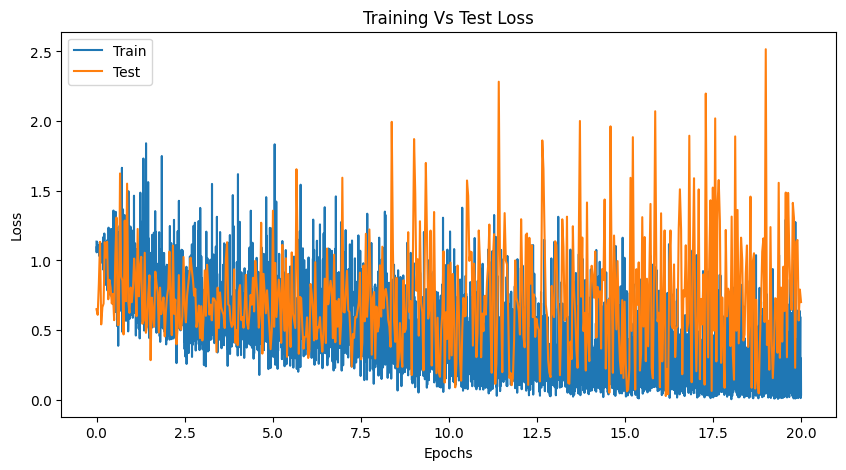

In [46]:
_ = plt.figure(figsize=(10, 5))
_ = plt.plot(np.linspace(0, nepochs, len(training_loss_logger)), training_loss_logger)
_ = plt.plot(np.linspace(0, nepochs, len(test_loss_logger)), test_loss_logger)

_ = plt.legend(["Train", "Test"])
_ = plt.title("Training Vs Test Loss")
_ = plt.xlabel("Epochs")
_ = plt.ylabel("Loss")

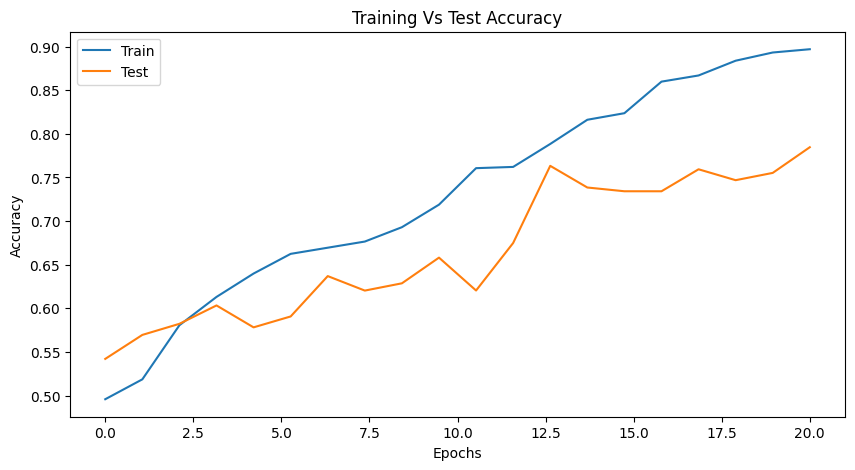

In [31]:
_ = plt.figure(figsize=(10, 5))
_ = plt.plot(np.linspace(0, nepochs, len(training_acc_logger)), training_acc_logger)
_ = plt.plot(np.linspace(0, nepochs, len(test_acc_logger)), test_acc_logger)

_ = plt.legend(["Train", "Test"])
_ = plt.title("Training Vs Test Accuracy")
_ = plt.xlabel("Epochs")
_ = plt.ylabel("Accuracy")